In [3]:
from __future__ import (absolute_import, 
                        division, 
                        print_function, 
                        unicode_literals)

import os
import glob
import time
import math
import random
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
import pylab
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import tensorflow as tf
from PIL import Image
from mpl_toolkits.axes_grid1 import ImageGrid
from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Set random seed for consistency
random.seed(100) 
np.random.seed(100)
tf.random.set_seed(100)

# Displays all outputs of a cell (not just last output)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

%matplotlib inline
plt.rcParams['figure.figsize'] = [16, 5]
print('TensorFlow version:', tf.__version__)
print('Keras version:', tf.keras.__version__)

TensorFlow version: 2.1.0
Keras version: 2.2.4-tf


In [4]:
work_dir = '.'
data_dir = os.path.join(work_dir, 'data')
data_arr_dir = os.path.join(work_dir, 'data_arr')
model_dir = os.path.join(work_dir, 'saved_models')

# Original data (before split)
black_measles_dir = os.path.join(data_dir, 'black_measles')
black_rot_dir = os.path.join(data_dir, 'black_rot')
leaf_blight_dir = os.path.join(data_dir, 'leaf_blight')
healthy_dir = os.path.join(data_dir, 'healthy')

# Train/Validation/Test
train_dir = os.path.join(data_dir, 'train')
validation_dir = os.path.join(data_dir, 'validation')
test_dir = os.path.join(data_dir, 'test')

# Training data by class
train_black_measles_dir = os.path.join(train_dir, 'black_measles')
train_black_rot_dir = os.path.join(train_dir, 'black_rot')
train_leaf_blight_dir = os.path.join(train_dir, 'leaf_blight')
train_healthy_dir = os.path.join(train_dir, 'healthy')

# Validation data by class
validation_black_measles_dir = os.path.join(validation_dir, 'black_measles')
validation_black_rot_dir = os.path.join(validation_dir, 'black_rot')
validation_leaf_blight_dir = os.path.join(validation_dir, 'leaf_blight')
validation_healthy_dir = os.path.join(validation_dir, 'healthy')

# Test data by class
test_black_measles_dir = os.path.join(test_dir, 'black_measles')
test_black_rot_dir = os.path.join(test_dir, 'black_rot')
test_leaf_blight_dir = os.path.join(test_dir, 'leaf_blight')
test_healthy_dir = os.path.join(test_dir, 'healthy')

In [5]:
#helper function to convert an image into a numpy array

def read_img(filepath, size):
    img = image.load_img(filepath, target_size=size)
    img = image.img_to_array(img)
    return img
    



C:\Users\revan\Anaconda3\lib\site-packages\matplotlib\figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


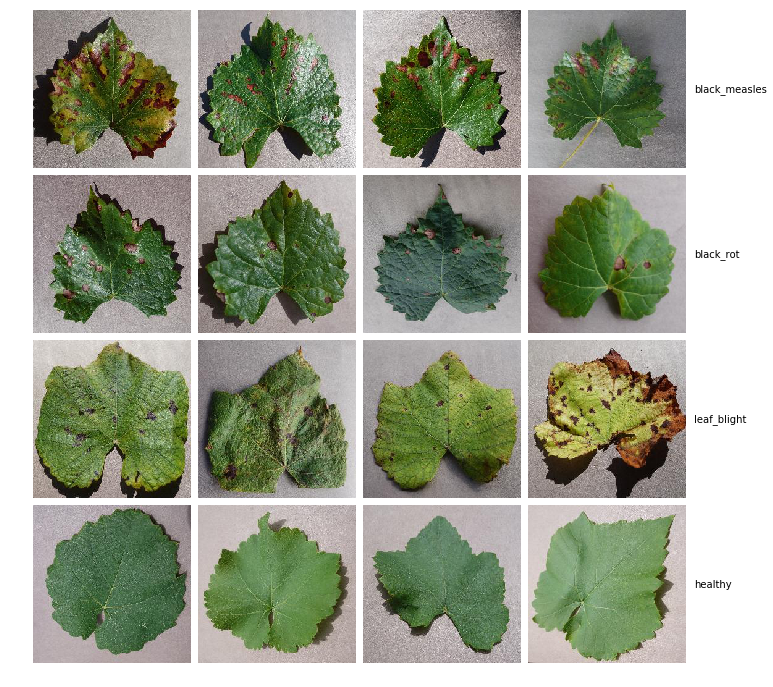

In [6]:
CATEGORIES = ['black_measles', 'black_rot', 'leaf_blight', 'healthy']
NUM_CATEGORIES = len(CATEGORIES)
height, width = 256, 256

# Create image grid
fig = plt.figure(num=1, figsize=(12,12))
grid = ImageGrid(fig, 111, nrows_ncols=(NUM_CATEGORIES,NUM_CATEGORIES),
                 axes_pad=0.1) # pad between axes in inch.

# Plot each example image per grid square
i = 0
for category in CATEGORIES:

    for j in range(4):
        
        ax = grid[i]
        path = os.path.join(data_dir, category)
        file = category + str(j) + '.jpg'
        img = read_img(os.path.join(path, file), size=(height, width))
        ax.imshow(img/255., interpolation='nearest', aspect='auto')
        ax.axis('off')
        if i % NUM_CATEGORIES == NUM_CATEGORIES - 1:
            
            
            ax.text(x=height*1.05, y=height//2, s=category, verticalalignment='center')
        i += 1

fig.show();

In [7]:
# Black measles Numpy array
os.makedirs(os.path.join(data_arr_dir), exist_ok=True)

black_measles_arr = [read_img(os.path.join(train_black_measles_dir, img), \
                    (256, 256)) for img in os.listdir(train_black_measles_dir)]

# Black rot Numpy array
black_rot_arr = [read_img(os.path.join(train_black_rot_dir, img), \
                 (256, 256)) for img in os.listdir(train_black_rot_dir)]

# Leaf blight Numpy array
leaf_blight_arr = [read_img(os.path.join(train_leaf_blight_dir, img), \
                   (256, 256)) for img in os.listdir(train_leaf_blight_dir)]

# Healthy Numpy array
healthy_arr = [read_img(os.path.join(train_healthy_dir, img),\
               (256, 256)) for img in os.listdir(train_healthy_dir)]

# Save Numpy arrays of images
np.save(os.path.join(data_arr_dir, 'black_measles.npy'), arr=black_measles_arr)
np.save(os.path.join(data_arr_dir, 'black_rot.npy'), arr=black_rot_arr)
np.save(os.path.join(data_arr_dir, 'leaf_blight.npy'), arr=leaf_blight_arr)
np.save(os.path.join(data_arr_dir, 'healthy.npy'), arr=healthy_arr)

In [8]:
# Load Numpy arrays of images
black_measles_arr = np.load(os.path.join(data_arr_dir, 'black_measles.npy'))
black_rot_arr = np.load(os.path.join(data_arr_dir, 'black_rot.npy'))
leaf_blight_arr = np.load(os.path.join(data_arr_dir, 'leaf_blight.npy'))
healthy_arr = np.load(os.path.join(data_arr_dir, 'healthy.npy'))

In [9]:
# Reshape arrays
black_measles_arr = black_measles_arr.reshape(886, 256*256*3)
black_rot_arr = black_rot_arr.reshape(756, 256*256*3)
leaf_blight_arr = leaf_blight_arr.reshape(689, 256*256*3)
healthy_arr = healthy_arr.reshape(272, 256*256*3)

In [18]:
def pca(X=np.array([]), no_dims=50):
    
    
    """
  Runs PCA on an array X to reduce its dimensoinality to 
  no_dims dimensions.
  @param X - the data matrix to reduce dimensionality
  @param no_dims - the number of dimensions to reduce dimensionality to
  """
    print('Running PCA on the data...')
    mean_vec = np.mean(a=X, axis=0)
    X_cov = (X-mean_vec).T.dot(X-mean_vec) / (X.shape[0]-1)
    eig_vals, eig_vecs = np.linalg.eig(X_cov.T)
    idx = np.argsort(np.abs(eig_vals))[::-1]
    eig_vecs = eig_vecs[:, idx]
    Y = np.dot(X, eig_vecs[:, 0:no_dims])
    return Y
    
def plot_scatter(x, labels): 
    
#       """
#   Function to create a scatter plot for visualization of data
#   along with respective colors/labels.
#   @param X - 2D Numpy array of data reduced to 2-dimensions using t-SNE or PCA
#   @param labels - 1D Numpy array of class label strings
#   """
    num_classes = len(np.unique(labels))
    color_palette = np.array(sns.color_palette('hls', num_classes))
    f = plt.figure(figsize=(10,10))
    ax = plt.subplot(aspect='equal')
    for i, label in enumerate(np.unique(labels)):
        
        idx = np.where(labels == label)
        ax.scatter(x[idx,0], x[idx,1], s=30, alpha=0.6, 
                    c=[color_palette[i]], label=label)
    ax.legend(loc='best', fontsize='medium')
    ax.axis('off')
    ax.axis('tight')
    plt.title('Representation of Classes')

In [21]:
# Create the 1D array of class labels
black_measles_lab = np.full(black_measles_arr.shape[0], 'black_measles')
black_rot_lab = np.full(black_rot_arr.shape[0], 'black_rot')
leaf_blight_lab = np.full(leaf_blight_arr.shape[0], 'leaf_blight')
healthy_lab = np.full(healthy_arr.shape[0], 'healthy')

labels = (black_measles_lab, black_rot_lab, leaf_blight_lab, healthy_lab)
labels = np.hstack(labels)

In [22]:
# Create a stacked array of the training instances 
data_tuple = (black_measles_arr, black_rot_arr, leaf_blight_arr, healthy_arr)
data = np.vstack(tup=data_tuple)/255. # normalize

In [23]:
# Run PCA on data
start = time.time()
pca = PCA(n_components=50)
data_pca = pca.fit_transform(data)
end = time.time()

print('Took {:.2f} seconds.'.format(end-start))

Took 38.15 seconds.


In [24]:

# Run t-SNE on data
start = time.time()
tsne = TSNE(n_components=2)
data_tsne = tsne.fit_transform(data_pca)
end = time.time()

print('Took {:.2f} seconds'.format(end-start))

Took 54.99 seconds


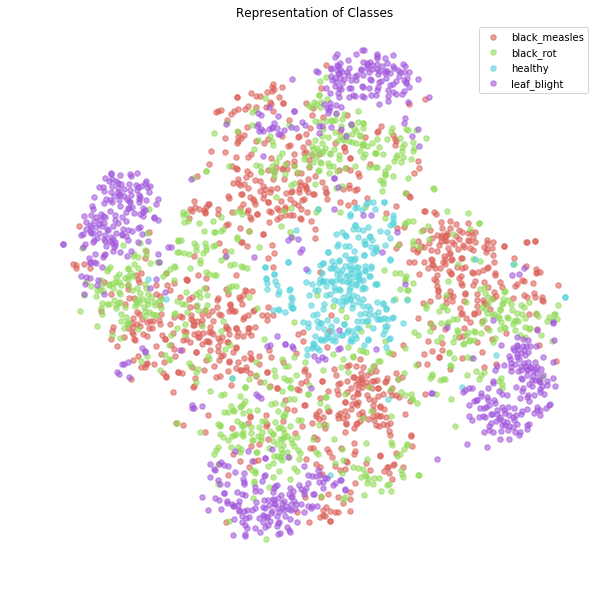

In [25]:
# Visualize the 2D class scatter plot
plot_scatter(data_tsne, labels);